In [1]:
import tifffile
import numpy as np
import fastplotlib as fpl
from matplotlib import pyplot as plt

using: <jupyter_rfb._jpg.SimpleJpegEncoder object at 0x7f9b37503490>


In [2]:
frame = tifffile.imread("/home/kushal/lab/datasets/adam_cohen/1/230938PP071_cre_30x_P17_Cell1_D4.tiff")
movie = np.memmap("/home/kushal/Downloads/frames.bin", dtype=np.uint16)

xdim, ydim = frame.shape
nframes = movie.size / (xdim * ydim)
assert nframes.is_integer()
nframes = int(nframes)

border_trim = 10

movie = movie.reshape(nframes, xdim, ydim)[:9_000, border_trim:-border_trim, border_trim:-border_trim]
xdim = movie.shape[1]
ydim = movie.shape[2]

In [3]:
movie_mean = movie.mean(axis=0)

In [4]:
iw = fpl.ImageWidget(
    movie, 
    cmap="gnuplot2",
    frame_apply={0: lambda f: f - movie_mean},
)
iw.show()

RFBOutputContext()

/home/kushal/repos/fastplotlib/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [5]:
iw.managed_graphics[0].world_object.add_event_handler(lambda ev: print(ev.pick_info), "click")

<function __main__.<lambda>(ev)>

In [6]:
iw.frame_apply = {0: lambda f: f - movie_mean}

In [7]:
iw.cmap = "gnuplot2_r"

In [8]:
from scipy.sparse.linalg import svds

In [9]:
start_ix, stop_ix = 407 - 100, 425 + 100

In [10]:
snippet = movie[start_ix:stop_ix] - movie_mean

In [11]:
snippet.shape

(218, 164, 884)

In [12]:
frame = snippet[10]

In [13]:
frame.shape

(164, 884)

In [14]:
delay = 1

In [15]:
n_pixels = xdim * ydim
n_steps = 20

In [16]:
n_timepoints = snippet.shape[0]

In [17]:
A = np.zeros((n_pixels * n_steps, n_timepoints))
A.shape

(2899520, 218)

In [20]:
from itertools import product
from tqdm import tqdm

In [21]:
for pixel_ix, (x, y) in tqdm(enumerate(product(range(xdim), range(ydim))), total=n_pixels):
    for step in range(n_steps):
        # A[(n_steps * pixel_ix) + step] = (n_steps * pixel_ix) + step
        A[(n_steps * pixel_ix) + step] = np.roll(snippet[:, x, y], shift=delay * step)

100%|████████████████████████████████████████████████████████████████████████████████████| 144976/144976 [00:19<00:00, 7574.55it/s]


In [32]:
plot = fpl.Plot()

plot.add_heatmap(A[30000:35000])

plot.show()

RFBOutputContext()

/home/kushal/repos/fastplotlib/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [23]:
k = 10

In [24]:
u, s, v = svds(A)

In [28]:
u = u[:, ::-1]
s = s[::-1]
v = v[::-1, :]

In [29]:
u.shape, s.shape, v.shape

((2899520, 6), (6,), (6, 218))

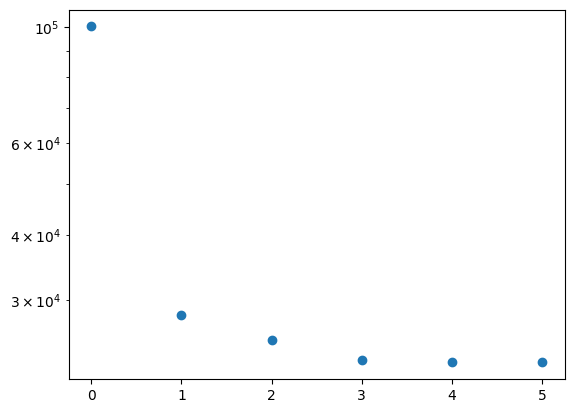

In [31]:
plt.scatter(x=np.arange(s.size), y=s)
plt.yscale("log")